<a href="https://colab.research.google.com/github/vaguiar/camelyon_dl_2019/blob/master/Cancer%20Prediction%3A%20End%20to%20End.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip  install tf-nightly-2.0-preview
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import io
import cv2
# The code in this notebook should work identically in TF v1 and v2
import tensorflow as tf
import zipfile

import tensorflow.keras.applications as applications
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required


%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from PIL import Image
from skimage.color import rgb2gray

You have version 2.0.0-dev20190514


In [3]:
GCP_PROJECT_ID = 'triple-voyage-239123'
GCP_BUCKET_NAME = 'vaa2114_dl_2019'

!gcloud config set project {GCP_PROJECT_ID}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



In [4]:
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{"model/"} {"/tmp"}

Copying gs://vaa2114_dl_2019/model/level3_window_800.h5...
Copying gs://vaa2114_dl_2019/model/level5_window_400.h5...
Copying gs://vaa2114_dl_2019/model/level7_window_50.h5...
/ [3/3 files][293.0 MiB/293.0 MiB] 100% Done                                    
Operation completed over 3 objects/293.0 MiB.                                    


In [0]:
!mkdir /tmp/slides

In [6]:
## 94, 35, 57
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{"slides/tumor_094.tif"} {"/tmp/slides/"}
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{"slides/tumor_094_mask.tif"} {"/tmp/slides/"}
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{"slides/tumor_035.tif"} {"/tmp/slides/"}
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{"slides/tumor_035_mask.tif"} {"/tmp/slides/"}
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{"slides/tumor_057.tif"} {"/tmp/slides/"}
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{"slides/tumor_057_mask.tif"} {"/tmp/slides/"}
  
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{"slides/tumor_101.tif"} {"/tmp/slides/"}
!gsutil -m cp -r gs://{GCP_BUCKET_NAME}/{"slides/tumor_101_mask.tif"} {"/tmp/slides/"}

Copying gs://vaa2114_dl_2019/slides/tumor_094.tif...
| [1/1 files][  1.5 GiB/  1.5 GiB] 100% Done  69.7 MiB/s ETA 00:00:00           
Operation completed over 1 objects/1.5 GiB.                                      
Copying gs://vaa2114_dl_2019/slides/tumor_094_mask.tif...
- [1/1 files][ 51.8 MiB/ 51.8 MiB] 100% Done                                    
Operation completed over 1 objects/51.8 MiB.                                     
Copying gs://vaa2114_dl_2019/slides/tumor_035.tif...
/ [1/1 files][  1.5 GiB/  1.5 GiB] 100% Done  27.9 MiB/s ETA 00:00:00           
Operation completed over 1 objects/1.5 GiB.                                      
Copying gs://vaa2114_dl_2019/slides/tumor_035_mask.tif...
- [1/1 files][ 93.7 MiB/ 93.7 MiB] 100% Done                                    
Operation completed over 1 objects/93.7 MiB.                                     
Copying gs://vaa2114_dl_2019/slides/tumor_057.tif...
| [1/1 files][  1.4 GiB/  1.4 GiB] 100% Done  31.6 MiB/s ETA 00:00:00    

In [0]:
TUMOR_CLASS = 1
NON_TUMOR_CLASS = 0
CLASS_NAMES = ['non_tumor', 'tumor']

In [0]:
def getSlide_Mask(slide_file, tumor_mask_file):

  

  slide = open_slide(slide_file)
  tumor_mask = open_slide(tumor_mask_file)
  
  # some slides have more than 8 levels, since we will only use the first 8 levels 
  # we will only assert that the first 8 levels have the appropriate dimensions 
  for i in range(8):  
      assert tumor_mask.level_dimensions[i][0] == slide.level_dimensions[i][0]
      assert tumor_mask.level_dimensions[i][1] == slide.level_dimensions[i][1]

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
  
  return slide, tumor_mask

def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im
  
  
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])
  
def preprocess_image(img, shape = 160):
  img1 = cv2.resize(img, (shape, shape))
  img1 = np.array(img1).reshape((1, shape, shape, 3))#do not miss the order in tuple
  return img1

def gen_slides(slide, 
               x, 
               y, 
               window_3 = 800, 
               window_5 = 400, 
               window_7 = 50):
  
  slide_3 = read_slide(slide, 
                       x=x, 
                       y=y, 
                       level=3, 
                       width= window_3, 
                       height= window_3)
  
  slide_5 = read_slide(slide, 
                       x= int(x - window_5*.25*int(slide.level_downsamples[int(5)])), 
                       y= int(y - window_5*.25*int(slide.level_downsamples[int(5)])), 
                       level=5, 
                       width= window_5, 
                       height= window_5)



  slide_7 = read_slide(slide, 
                       x= int(x - window_7*.25*int(slide.level_downsamples[int(7)])), 
                       y= int(y - window_7*.25*int(slide.level_downsamples[int(7)])), 
                       level=7, 
                       width= window_7, 
                       height= window_7)
  
  return slide_3, slide_5, slide_7 

def get_XY_vote(slide, x, y, tissue_thres = .4):
 

  slide_3, slide_5, slide_7 = gen_slides(slide, x, y)
  
  tissue_pixels = find_tissue_pixels(slide_3)
  num_pixels = len(list(tissue_pixels))
  pcnt_tissue = num_pixels/ float(slide_3.shape[0] * slide_3.shape[0])
  
  if pcnt_tissue <= tissue_thres:
    
    return NON_TUMOR_CLASS, (slide_3, slide_5, slide_7)
  
  else:
  
    slide_3_pro = preprocess_image(slide_3)
    slide_5_pro = preprocess_image(slide_5)
    slide_7_pro = preprocess_image(slide_7)

    pred_3 = np.argmax(level3.predict(slide_3_pro), axis =1)[0]
    pred_5 = np.argmax(level5.predict(slide_5_pro), axis =1)[0]
    pred_7 = np.argmax(level7.predict(slide_7_pro), axis =1)[0]

    vote = 0 if sum([pred_3*2, pred_5, pred_7*.4]) ==0 else 1 #/3.0 < .5 else 1
    
    
    print("X-coord:{}, % Y-coord:{}, Vote:{}, Model 3 Prediction:{}, Model 5 Prediction:{}, Model 7 Prediction:{}".format(x,y, vote, pred_3, pred_5, pred_7))
    

    return vote , (slide_3, slide_5, slide_7, pred_3, pred_5, pred_7)
  
def modify_heat_map(heat_map, 
                    x,
                    y,
                    downsample_factor, 
                    window, 
                    target_shape): ## level 5 dimensions
    
  x_down = int(x/downsample_factor)
  y_down = int(y/downsample_factor)

  for x in range(x_down, x_down+window):
    for y in range (y_down, y_down+window):

      if x >= target_shape[0]:
        pass

      elif y >= target_shape[1]:
        pass
      else:
        heat_map[y][x] = 1 

  return heat_map
  
  
def get_tumor_coor_prediction(slide, pred_level=3, window = 400):

  levl_3_downsampling = slide.level_downsamples[pred_level]
  level_3_dimensions = slide.level_dimensions[pred_level]

  tumor_slides = []

  for x in range(0, int(level_3_dimensions[0]), window):
    for y in range(0, int(level_3_dimensions[1]),window):

      x_2 = x*int(slide.level_downsamples[pred_level])
      y_2 = y*int(slide.level_downsamples[pred_level])

      vote, slide_preds = get_XY_vote(slide, x_2 , y_2)


      if vote == TUMOR_CLASS:
        tumor_slides.append((x_2,y_2,window))
   
  return tumor_slides

In [0]:
def get_heat_map(slide, tumor_mask, tumor_slides, level = 5, target_shape = (3712, 3136)):

  mask_image_lvl = read_slide(tumor_mask, 
                           x=0, 
                           y=0, 
                           level=level, 
                           width=slide.level_dimensions[level][0], 
                           height=slide.level_dimensions[level][1])

  heat_map = mask_image_lvl[:,:,0]*0


  for x,y,window in tumor_slides:

    heat_map = modify_heat_map(heat_map, x,y,int(slide.level_downsamples[level]), int(100),target_shape)

  plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(slide_image_orig)
  plt.imshow(heat_map, cmap='jet', alpha=0.5) # Red regions contains cancer.
  
  return heat_map

In [0]:
import itertools
from sklearn.metrics import confusion_matrix



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        print('')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    
def plot_evaluation(mask_image, mask_pred):


  pred = mask_pred.flatten()
  true = mask_image.flatten()

  confusion_matrix_new = confusion_matrix(true, pred)
  plot_confusion_matrix(confusion_matrix_new, CLASS_NAMES, normalize= True)

# Making Predictions

In [0]:
level5 = load_model('/tmp/model/level5_window_400.h5')
level3 = load_model('/tmp/model/level3_window_800.h5')
level7 = load_model('/tmp/model/level7_window_50.h5')

## Slide **94**

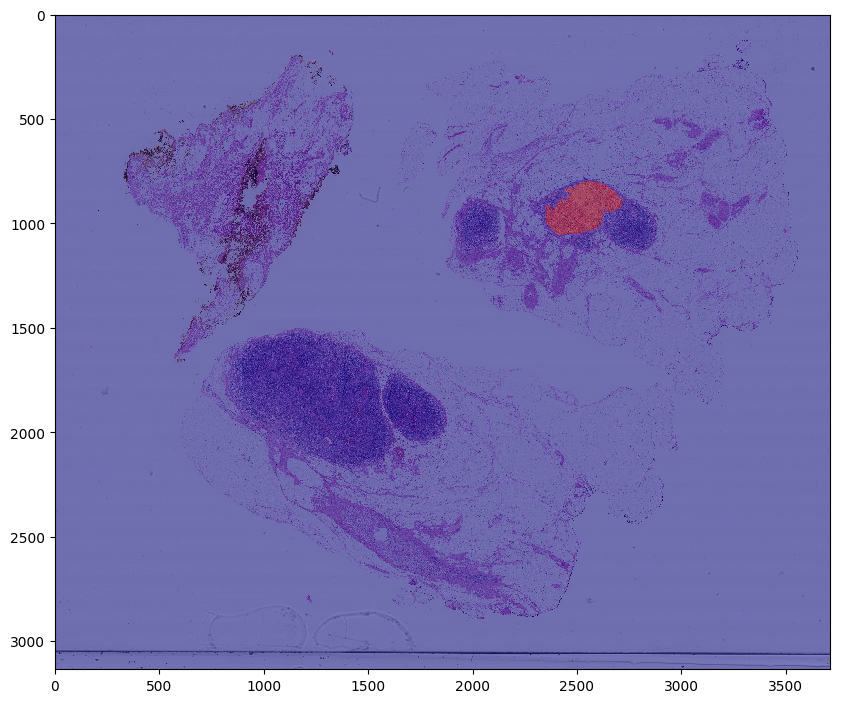

In [74]:
slide_file= '/tmp/slides/tumor_101.tif'
tumor_mask_file  = '/tmp/slides/tumor_101_mask.tif'

  
slide, tumor_mask = getSlide_Mask(slide_file, tumor_mask_file)

slide_image_orig = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

mask_image_orig = read_slide(tumor_mask, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

mask_image_orig = mask_image_orig[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image_orig)
plt.imshow(mask_image_orig, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [106]:
vote, slide_imgs = get_XY_vote(slide, 2000*int(slide.level_downsamples[5]), 1000*int(slide.level_downsamples[5]))

X-coord:64000, % Y-coord:32000, Vote:0, Model 3 Prediction:0, Model 5 Prediction:0, Model 7 Prediction:0


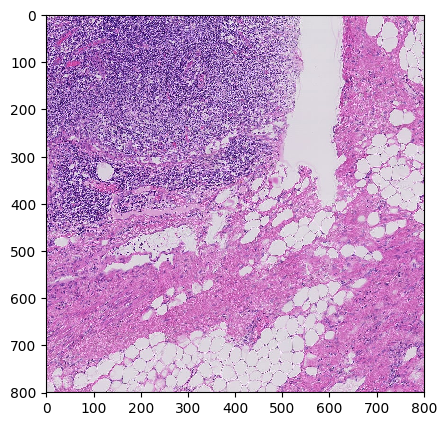

In [107]:
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_imgs[0])

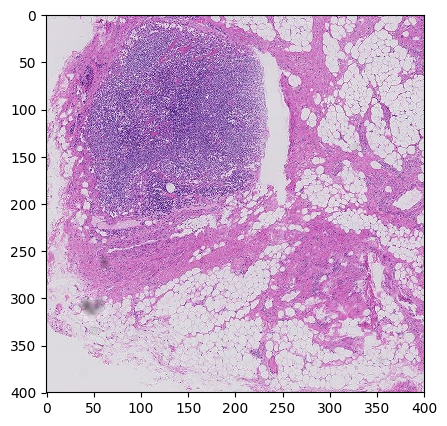

In [87]:
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_imgs[1])

In [0]:
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(slide_imgs[2])

In [0]:
tumor_slides = get_tumor_coor_prediction(slide)

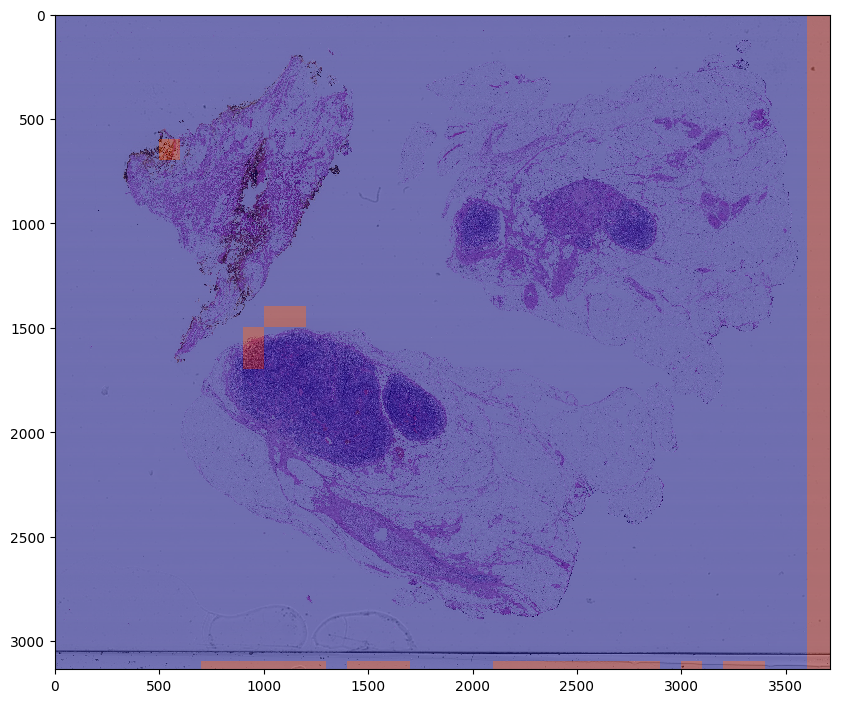

In [114]:
mask_pred = get_heat_map(slide, tumor_mask, tumor_slides)

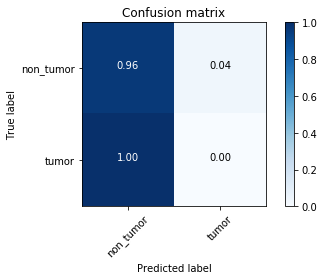

In [113]:
plot_evaluation(mask_image_orig, mask_pred)

## Slide 94

In [0]:
slide_file= '/tmp/slides/tumor_094.tif'
tumor_mask_file  = '/tmp/slides/tumor_094_mask.tif'

  
slide, tumor_mask = getSlide_Mask(slide_file, tumor_mask_file)

slide_image_orig = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

mask_image_orig = read_slide(tumor_mask, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

mask_image_orig = mask_image_orig[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image_orig)
plt.imshow(mask_image_orig, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [0]:
tumor_slides = get_tumor_coor_prediction(slide)

In [0]:
mask_pred = get_heat_map(slide, tumor_mask, tumor_slides, target_shape= slide.level_dimensions[5])

In [0]:
plot_evaluation(mask_image_orig, mask_pred)

## Slide 57

In [0]:
slide_file= '/tmp/slides/tumor_057.tif'
tumor_mask_file  = '/tmp/slides/tumor_057_mask.tif'

  
slide, tumor_mask = getSlide_Mask(slide_file, tumor_mask_file)

slide_image_orig = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

mask_image_orig = read_slide(tumor_mask, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

mask_image_orig = mask_image_orig[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image_orig)
plt.imshow(mask_image_orig, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [0]:
tumor_slides = get_tumor_coor_prediction(slide)

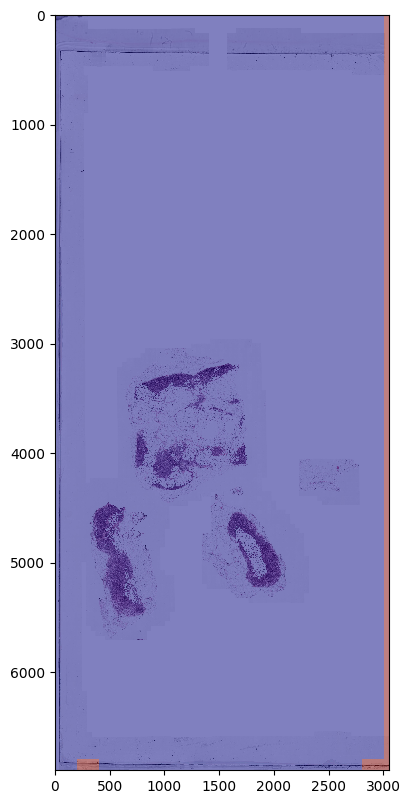

In [123]:
mask_pred = get_heat_map(slide, tumor_mask, tumor_slides, target_shape= slide.level_dimensions[5])

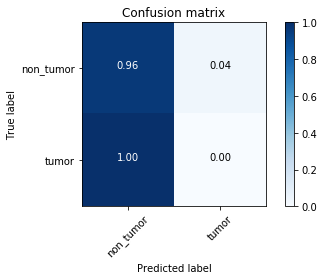

In [124]:
plot_evaluation(mask_image_orig, mask_pred)

## Slide 35


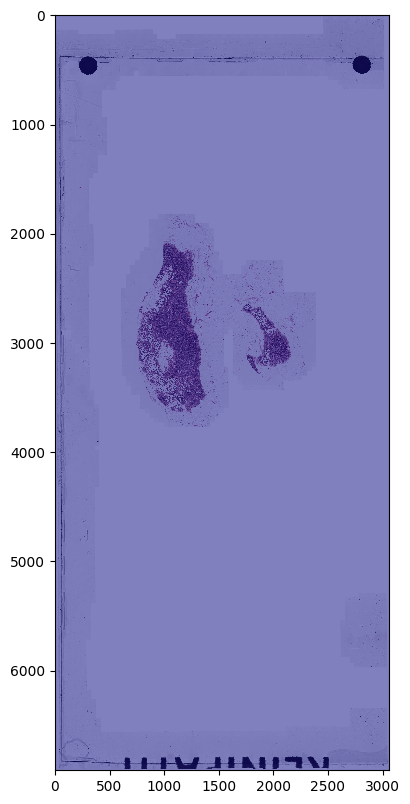

In [126]:
slide_file= '/tmp/slides/tumor_035.tif'
tumor_mask_file  = '/tmp/slides/tumor_035_mask.tif'

  
slide, tumor_mask = getSlide_Mask(slide_file, tumor_mask_file)

slide_image_orig = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

mask_image_orig = read_slide(tumor_mask, 
                         x=0, 
                         y=0, 
                         level=5, 
                         width=slide.level_dimensions[5][0], 
                         height=slide.level_dimensions[5][1])

mask_image_orig = mask_image_orig[:,:,0]

plt.figure(figsize=(10,10), dpi=100)
plt.imshow(slide_image_orig)
plt.imshow(mask_image_orig, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [0]:
tumor_slides = get_tumor_coor_prediction(slide)

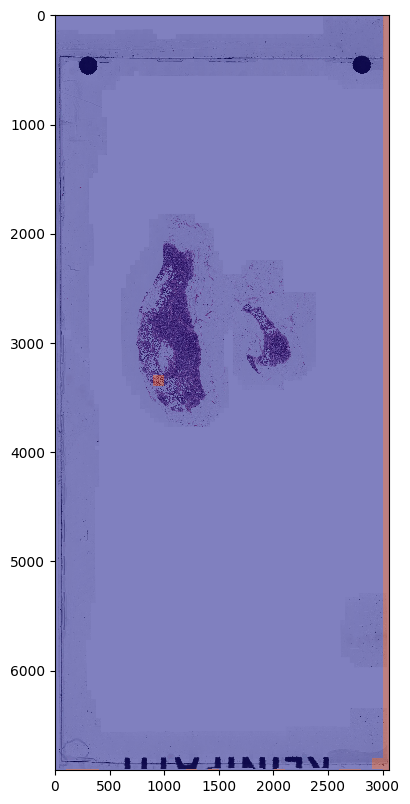

In [129]:
mask_pred = get_heat_map(slide, tumor_mask, tumor_slides,target_shape= slide.level_dimensions[5])

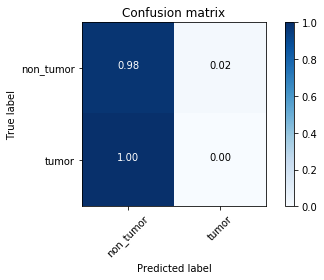

In [132]:
plot_evaluation(mask_image_orig, mask_pred)